In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#basics
import sys,os
sys.path.insert(1, os.path.dirname(os.getcwd()))

#utils
import paths

#main libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.precision", 4)
%matplotlib inline

#model Libraries
from sklearn import utils
from sklearn import preprocessing

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GroupKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error


#skopt
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from tune_sklearn import TuneSearchCV

In [3]:
#private modules 
#data
from src.data import make_dataset

#utils
from src.utils import memory_usage

#models
from src.models import train_model
from src.models import evaluation

#validation
from src.validation import metrics
from src.validation import metrics_description

#sklearn
from sklearn.model_selection import GroupKFold

In [27]:
%%time
df_training,features,target = make_dataset.get_data(nrows=None,
                                                    low_memory=True, 
                                                    dataset="training", 
                                                    feather=True) #false on AWS/colab

low memory activated
Memory usage after optimization is: 309.15 MB
Decreased by 49.1%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501808 entries, 0 to 501807
Columns: 314 entries, id to target_kazutsugi
dtypes: float16(311), int32(1), object(2)
memory usage: 307.2+ MB
None
CPU times: user 55.9 s, sys: 1min 45s, total: 2min 41s
Wall time: 5min


In [15]:
%%time
df_validation,features,target = make_dataset.get_data(nrows=None,
                                                    low_memory=True, 
                                                    dataset="validation", 
                                                    feather=True)

low memory activated
Memory usage after optimization is: 65.86 MB
Decreased by 49.1%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106895 entries, 0 to 106894
Columns: 314 entries, id to target_kazutsugi
dtypes: float16(311), int32(1), object(2)
memory usage: 65.4+ MB
None
CPU times: user 6.91 s, sys: 3.37 s, total: 10.3 s
Wall time: 11.5 s


### 2a Parte: Pycaret Linear Models

In [20]:
load_table = pd.read_excel("../../reports/pycaret_compare_results.xlsx", index=True)
load_table

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Orthogonal Matching Pursuit,0.3012,0.1244,0.3527,0.0015,0.2461,0.4623,1.3055
1,Bayesian Ridge,0.3009,0.1244,0.3527,0.0019,0.2461,0.4616,37.0157
2,Ridge Regression,0.3017,0.1245,0.3528,0.0013,0.2461,0.4637,6.7043
3,Linear Regression,0.3017,0.1245,0.3528,0.0013,0.2461,0.4637,6.2805
4,Automatic Relevance Determination,0.3008,0.1245,0.3529,0.0009,0.2462,0.4607,14.4360
5,Lasso Regression,0.2991,0.1246,0.3530,0.0000,0.2463,0.4565,2.7285
6,Elastic Net,0.2991,0.1246,0.3530,0.0000,0.2463,0.4565,2.0007
7,Least Angle Regression,0.3022,0.1246,0.3530,-0.0002,0.2463,0.4649,1.4324
8,Lasso Least Angle Regression,0.2991,0.1246,0.3530,0.0000,0.2463,0.4565,1.4809


### 3a Treinamento modelos (ilustrativo)?

In [9]:
#Group K-fold
CV = GroupKFold(n_splits = 3)
grp = list(CV.split(X = df_training[features], y = df_training[target],  groups = df_training.era.values))

from sklearn.metrics import mean_squared_error
scorer = make_scorer(mean_squared_error)

results, res_cv = list(), dict()

In [10]:
from xgboost import XGBRegressor


xgb_param_grid = {
        'colsample_bylevel' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0],
        'colsample_bytree' :[0.6, 0.7, 0.8, 1.0],
        'gamma' : list(np.linspace(0.05, 1, 6)),
        'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
        'max_depth' : list(range(3, 30, 3)),
        'min_child_weight' : list(range(1, 11, 2)),
        'n_estimators' : list(range(5, 20, 5)),
        'reg_alpha' : list(np.logspace(-1, 1, num=10)/10),
        'reg_lambda' : list(np.logspace(-1, 1, num=10)/10),
        'subsample' : [0.6, 0.7, 0.8, 1.0],
        'scale_pos_weight' : [1, 10, 25, 50, 75, 99, 100, 1000, 3000,5000, 10000],
        'objective': ["reg:squarederror"]
}

result = evaluation.evaluate_model(df_training[features], df_training[target],
                                   XGBRegressor(), 'xgb',
                                   xgb_param_grid, 
                                   scorer, n_iter=3, 
                                   cv_folds=grp, pipeline=None)

results.append(result)
res_cv[result[1]] = evaluation.get_cv_scores(result[0])

==> Starting K-fold cross validation for xgb model, 5000 examples
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    1.6s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    2.5s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    3.6s finished


==> Elapsed seconds: 4.972
Best xgb model: XGBRegressor(colsample_bylevel=0.7, colsample_bytree=0.6, gamma=0.81,
             learning_rate=0.3, max_depth=21, min_child_weight=5,
             n_estimators=15, objective='reg:squarederror',
             reg_alpha=0.21544346900318834, reg_lambda=0.12915496650148842,
             scale_pos_weight=5000, subsample=0.6)
Best xgb score (val): 0.190


In [34]:
from platform import python_version

print(python_version())

3.8.3


In [23]:
load_baseline = pd.read_csv("../../reports/results_baseline.csv")
load_baseline

,outsample,insample,time_elapsed_GPU(s),time_elapsed(s)
LGBMRegressor,0.0447,0.2677,23.8324,62.3275
XGBRanker,0.0442,0.2021,67.5707,469.0444
XGBRegressor,0.0440,0.2667,37.2466,445.6100
LGBMClassifier,0.0305,0.2070,137.1966,301.8254
XGBClassifier,0.0302,0.1648,232.9470,2172.2911
CatBoostClassifier,0.0271,0.0959,19.0138,1193.6433
CatBoostRegressor,0.0267,0.0949,9.2403,209.8839
LGBMRanker,0.0150,0.0647,6092.7200,16133.8554


In [24]:
df_nomi = pd.read_csv("../../data/raw/numerai_datasets/numerai_training_validation_target_nomi.csv")

In [32]:
df_nomi.data_type.unique()

array(['train', 'validation'], dtype=object)

In [2]:
import lightgbm as lgbm
lgbm.__version__

'2.3.1'

In [1]:
import xgboost as xgb
xgb.__version__

'0.90'

### Parte 4 Avaliacao dos modelos Treinados e graficos

In [12]:
model

In [16]:
model = list(filter(lambda x: x[1] == 'xgb', results))[0][0]
preds = model.model.predict(df_validation[features])

Qtde. eras: 22
performance over time


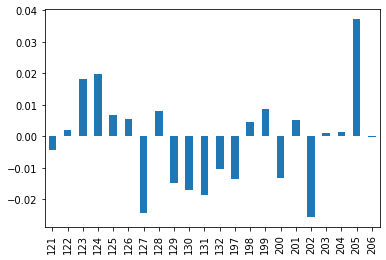

In [17]:
era_scores, era_df, df_metrics, feat_corrs = metrics.submission_metrics(df_validation, preds, model.name)

In [18]:
feat_corrs.describe()

count    310.0000
mean       0.0021
std        0.0304
min       -0.0745
25%       -0.0185
50%        0.0043
75%        0.0205
max        0.1547
dtype: float64

In [19]:
df_metrics

,Valor,Categoria,Range_Aceitavel,Descricao
Metrica,,,,
Model_Name,xgb,Submission,NA,Nome do Modelo
Max_Drawdown,-0.02566,Financeira,[0%..2%],Perda máxima em uma era
Validation_Corr,-0.001201,Submission,"[3.6%..4.4%] 4.8%, overfitting",Média spearman corr por era
Median_corr,0.001019,Estatistica,[3.6%..4.4%] Dentro do range de médias,Mediana spearman corr por era
Variance,0.0002252,Estatistica,[0..] Próximo a zero,Variancia spearman corr por era
Std_Dev,0.01501,Estatistica,[0..] Próximo a zero,Std spearman corr por era
AR(1),0.1366,Estatistica,[0..] Próximo a zero,AR(1) pearson corr eras[:-1] e eras[1:]
Skewness,0.427,Estatistica,[0..1],"Skewness, central moment **3"
Exc_Kurtosis,0.06905,Estatistica,[-1..0],Kurtosis central moment **4


##### Metricas regressao (melhorar para o SP)

In [17]:
model = list(filter(lambda x: x[1] == 'lr', results))[0][0]
preds = model.model.predict(model.pipeline.transform(df_validation[features]))

# Evaluate the model
print('Model performance on validation set:')
score = model.model.score(df_validation[features], df_validation[target])  #default deve ser o R2
mse = mean_squared_error(df_validation[target], preds)
print(f'Training R^2: {score}')
print(f'Training MSE: {mse}')

Model performance on validation set:
Training R^2: -0.010808492754463828
Training MSE: 0.12618499994277954


Qtde. eras: 22
performance over time


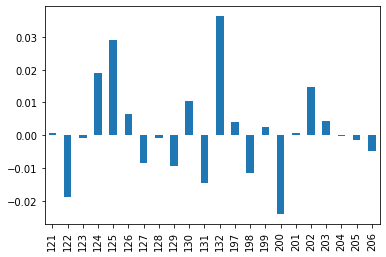

In [115]:
era_scores, era_df, df_metrics, feat_corrs = metrics.submission_metrics(df_validation, preds, model.name)

In [116]:
df_metrics

,Valor,Categoria,Range_Aceitavel,Descricao
Metrica,,,,
Model_Name,rf,Submission,NA,Nome do Modelo
Max_Drawdown,-0.02401,Financeira,[0%..2%],Perda máxima em uma era
Validation_Corr,0.001461,Submission,"[3.6%..4.4%] 4.8%, overfitting",Média spearman corr por era
Median_corr,0.0001883,Estatistica,[3.6%..4.4%] Dentro do range de médias,Mediana spearman corr por era
Variance,0.0001974,Estatistica,[0..] Próximo a zero,Variancia spearman corr por era
Std_Dev,0.01405,Estatistica,[0..] Próximo a zero,Std spearman corr por era
AR(1),-0.02083,Estatistica,[0..] Próximo a zero,AR(1) pearson corr eras[:-1] e eras[1:]
Skewness,0.6107,Estatistica,[0..1],"Skewness, central moment **3"
Exc_Kurtosis,0.374,Estatistica,[-1..0],Kurtosis central moment **4


### 5a Pate meta model

Rascunho

### Local training

In [28]:
memory_usage.memory()

Available memory (%): 13.227272033691406


In [7]:
results, res_cv = list(), dict()

In [6]:
#Group K-fold
CV = GroupKFold(n_splits = 3)
grp = list(CV.split(X = df_training[features], y = df_training[target],  groups = df_training.era.values))

In [ ]:
rf_param_grid =  {
    'reg_rf__n_estimators' : [10],
}


scorer = make_scorer(mean_squared_error)

result = evaluation.evaluate_model(df_training[features], df_training[target],
                                   LinearRegression(), 'reg_rf',
                                   lr_param_grid, 
                                   scorer, n_iter=1, 
                                   cv_folds=grp, pipeline=None)

results.append(result)
res_cv[result[1]] = evaluation.get_cv_scores(result[0])

In [ ]:
result[0].results

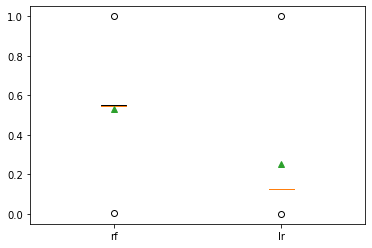

In [10]:
_ = plt.boxplot(res_cv.values(), labels=res_cv.keys(), showmeans=True)

In [11]:
#salvando o pipeline completo
file_path = '../../models/sao_paulo-pipeline.pkl'

model = list(filter(lambda x: x[1] == 'rf', results))[0][0]
model.save(file_path)

In [12]:
#salvando apenas o modelo
from joblib import dump, load
dump(model.model, '../../models/sao_paulo-baseline.pkl')

['../../models/sao_paulo-baseline.pkl']

In [13]:
#carregando o modelo
model_loaded = load(file_path)

>cores=1: 22.561 seconds
>cores=2: 13.700 seconds
>cores=3: 9.732 seconds
>cores=4: 9.550 seconds
>cores=5: 8.731 seconds
>cores=6: 8.896 seconds
>cores=7: 9.042 seconds
>cores=8: 9.022 seconds


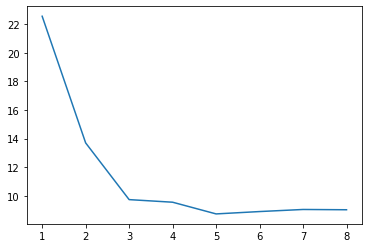

In [35]:
# example of comparing number of cores used during training to execution speed
from time import time
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
# define dataset
X, y = make_classification(n_samples=10000, n_features=20, n_informative=15, n_redundant=5, random_state=3)
results = list()
# compare timing for number of cores
n_cores = [1, 2, 3, 4, 5, 6, 7, 8]
for n in n_cores:
	# capture current time
	start = time()
	# define the model
	model = RandomForestClassifier(n_estimators=500, n_jobs=n)
	# fit the model
	model.fit(X, y)
	# capture current time
	end = time()
	# store execution time
	result = end - start
	print('>cores=%d: %.3f seconds' % (n, result))
	results.append(result)
pyplot.plot(n_cores, results)
pyplot.show()